# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-04-11 23:04:07--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  17.4MB/s    in 14s     

2020-04-11 23:04:21 (12.6 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-04-11 23:04:21--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  11.3MB/s    in 5.4s    

2020-04-11 23:04:26 (11.4 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2020-04-11 23:04:26--
Total wall clock time: 20s
Downloaded: 2 files, 235M in

In [0]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [0]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [0]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10)
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, print_full_history=True):    
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            loss_accum += loss_value

        if scheduler:
            scheduler.step()  # use the sheduler

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if print_full_history:
            print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        else:
            if epoch == 0 or epoch == (num_epochs - 1):
                print("Average loss: %f, Train accuracy: %f, Val accuracy: %f, epoch num: %i" % (ave_loss, train_accuracy, val_accuracy, epoch))
        
    return loss_history, train_history, val_history

        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """

    model.eval() # Evaluation mode
    # Don't forget to move the data to device before running it through the model!
    correct = 0
    total = 0
    for (x, y) in loader:
      x_gpu = x.to(device)
      y_gpu = y.to(device)
      pred = model(x_gpu)

      indices = torch.argmax(pred, 1)
      correct += torch.sum(indices == y_gpu)
      total += y_gpu.shape[0]
    
    return float(correct) / total

In [0]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)  # add sheduler
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.370235, Train accuracy: 0.890199, Val accuracy: 0.855573
Average loss: 0.366488, Train accuracy: 0.889653, Val accuracy: 0.843151
Average loss: 0.359449, Train accuracy: 0.892264, Val accuracy: 0.858098
Average loss: 0.355024, Train accuracy: 0.891683, Val accuracy: 0.851205
Average loss: 0.350557, Train accuracy: 0.893987, Val accuracy: 0.854140


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

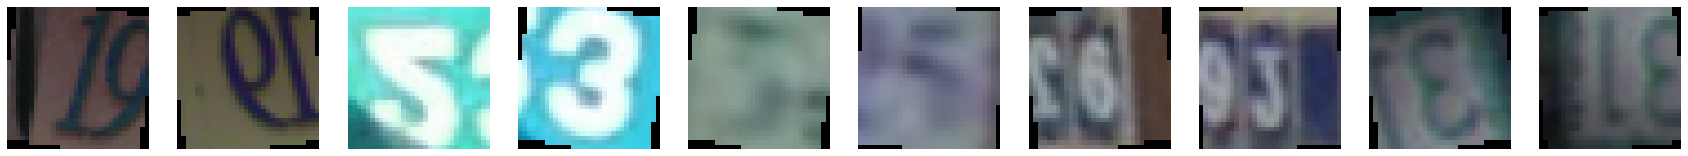

In [0]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [0]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

# TODO create new instances of loaders with the augmentations you chose
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

In [0]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation
loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.547490, Train accuracy: 0.837047, Val accuracy: 0.854481
Average loss: 0.480162, Train accuracy: 0.852336, Val accuracy: 0.864241
Average loss: 0.464104, Train accuracy: 0.859110, Val accuracy: 0.864446
Average loss: 0.456499, Train accuracy: 0.859656, Val accuracy: 0.849498
Average loss: 0.445704, Train accuracy: 0.864877, Val accuracy: 0.854686


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [0]:
# Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
                nn.Conv2d(3, 6, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                Flattener(),
                nn.Linear(16*5*5, 120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [0]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.332039, Train accuracy: 0.553322, Val accuracy: 0.799263
Average loss: 0.554227, Train accuracy: 0.835955, Val accuracy: 0.860010
Average loss: 0.465584, Train accuracy: 0.861806, Val accuracy: 0.870043
Average loss: 0.419195, Train accuracy: 0.875508, Val accuracy: 0.872773
Average loss: 0.382746, Train accuracy: 0.884688, Val accuracy: 0.876527
Average loss: 0.359842, Train accuracy: 0.892844, Val accuracy: 0.872227
Average loss: 0.337912, Train accuracy: 0.899311, Val accuracy: 0.887380
Average loss: 0.324927, Train accuracy: 0.902228, Val accuracy: 0.884923
Average loss: 0.311207, Train accuracy: 0.907484, Val accuracy: 0.894342
Average loss: 0.299666, Train accuracy: 0.908968, Val accuracy: 0.891134


# Подбор гиперпараметров

In [0]:
class GridSearch:
  "the random iteration"
  def __init__(self, *args):
    self.args = args
    
  def rand_iterator(self, num):
    from itertools import product
    from random import sample
    
    sample_list = list(product(*self.args))
    num = min(num, len(sample_list))
    return sample(sample_list, num)

In [0]:
from tqdm import tqdm_notebook

In [0]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_coeffs', 'anneal_epochs', 'regs'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-1, 1e-2, 1e-3]
anneal_coeffs = [0.2]
anneal_epochs = [5, 10, 15, 20]
regs = [1e-3, 1e-4, 1e-5]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

In [0]:
lenet_model = nn.Sequential(
                nn.Conv2d(3, 6, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                Flattener(),
                nn.Linear(16*5*5, 120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flattener()
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU(inplace=True)
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU(inplace=True)
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
full_params = Hyperparams(learning_rates, anneal_coeffs, anneal_epochs, regs)
grid_search = GridSearch(*full_params)
rand_iterator = grid_search.rand_iterator(50)

for params in tqdm_notebook(rand_iterator, total=len(rand_iterator)):
    params = Hyperparams(params[0], params[1], params[2], params[3])
    num_epochs = 10
    while num_epochs <= params.anneal_epochs:
        num_epochs *= 2
    print(f"num_epochs: {num_epochs}, params: {params}")
    
    optimizer = optim.SGD(lenet_model.parameters(), lr=params.learning_rate, weight_decay=params.regs)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params.anneal_epochs, gamma=params.anneal_coeffs)  # add sheduler
    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

    loss_history, train_history, val_history = train_model(lenet_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs, scheduler=scheduler, print_full_history=False)
    
    run_record[params] = RunResult(model=nn_model, train_history=train_history, val_history=val_history, final_val_accuracy=val_history[-1])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


num_epochs: 40, params: Hyperparams(learning_rate=0.1, anneal_coeffs=0.2, anneal_epochs=20, regs=1e-05)
Average loss: 2.239678, Train accuracy: 0.189179, Val accuracy: 0.189339, epoch num: 0
Average loss: 2.239362, Train accuracy: 0.189179, Val accuracy: 0.189339, epoch num: 39
num_epochs: 20, params: Hyperparams(learning_rate=0.01, anneal_coeffs=0.2, anneal_epochs=15, regs=1e-05)
Average loss: 2.239329, Train accuracy: 0.189179, Val accuracy: 0.189339, epoch num: 0


In [0]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

In [0]:
lenet_model = nn.Sequential(
                nn.Conv2d(3, 6, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                Flattener(),
                nn.Linear(16*5*5, 120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)  # add sheduler
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10, scheduler)

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [13]:
best_model = nn.Sequential(
                nn.Conv2d(3, 6, 5, padding=0),
                nn.BatchNorm2d(6),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5, padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                Flattener(),
                nn.Linear(16*5*5, 120),
                nn.BatchNorm1d(120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 84),
                nn.BatchNorm1d(84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10)
          )

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flattener()
  (9): Linear(in_features=400, out_features=120, bias=True)
  (10): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
optimizer = optim.Adam(best_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2)  # add sheduler
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 10, scheduler=scheduler)

Average loss: 0.214649, Train accuracy: 0.932328, Val accuracy: 0.911678
Average loss: 0.181904, Train accuracy: 0.942412, Val accuracy: 0.914477
Average loss: 0.205869, Train accuracy: 0.934444, Val accuracy: 0.911815
Average loss: 0.176995, Train accuracy: 0.943948, Val accuracy: 0.912497
Average loss: 0.205109, Train accuracy: 0.934239, Val accuracy: 0.909085
Average loss: 0.172584, Train accuracy: 0.944818, Val accuracy: 0.913726
Average loss: 0.200776, Train accuracy: 0.936030, Val accuracy: 0.908607
Average loss: 0.171292, Train accuracy: 0.945620, Val accuracy: 0.913794
Average loss: 0.196727, Train accuracy: 0.936508, Val accuracy: 0.907720
Average loss: 0.168917, Train accuracy: 0.946354, Val accuracy: 0.911883


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [19]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = compute_accuracy(best_model, train_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9755315155444835
